# Mini-project n° 4– RNN, LSTM and GRU vs MLP and CNN

## Importation des librairies

In [ ]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\janca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\janca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\janca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


cpu


## Chargment et étude préliminaire du jeu de données

In [2]:
data = pd.read_csv('data/IMDB Dataset.csv')

On transforme ensuite les labels des classes (ou sentiment) qui sont des chaînes de caractères en valeurs numériques. Le label "positive" ou "négative" renvoie à la critique des spectateurs ayant vu le film et ayant laissé un commentaire. Un sentiment "postifif" sera associé au label 1 tandis qu'un sentiment négatif sera associé au label 0.

In [3]:
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 642023.96it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [4]:
data.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

On remarque que le jeu de données est équilibré : la moitié des films ont reçu des critiques "positives" et l'autre moitié des critiques "négatives".

In [5]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:00<00:00, 54783.79it/s]


In [6]:
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

On s'intéresse ici à la longueur des commentaires positifs. En moyenne elle est d'environ 233 tokens et varie de 10 à 2470 tokens.

In [7]:
data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

En répétant le même processus pour les commentaires négatifs, on constate que la moyenne des commentaires négatifs, ainsi que les premiers, deuxième et troisième quartiles ont des longueurs proches de celles des commentaires positifs. Le nombre de tokens ne semblent donc pas influencer le type de commentaires (positifs ou négatifs). On le visualise aisément sur le boxplot suivant :

C:\Users\janca\AppData\Local\Temp\ipykernel_40228\127678021.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='token_length', data=data, palette='Set2')


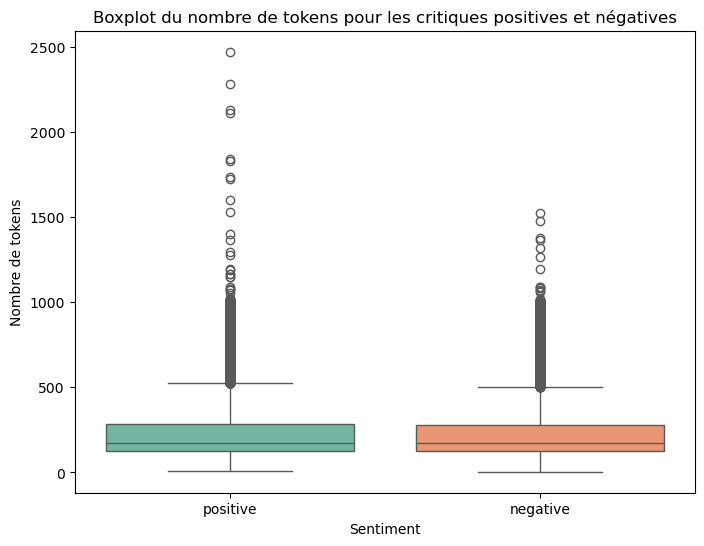

In [8]:
# Création du boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='token_length', data=data, palette='Set2')

plt.title('Boxplot du nombre de tokens pour les critiques positives et négatives')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de tokens')

plt.show()

On peut également visualiser quelques exemples de commentaires positifs et négatifs.

In [9]:
# Exemples de commentaires positifs
print('Positive')
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['review'].item())
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min() + 2]['review'].item())
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min() + 4]['review'].item())
print()

# Exemples de commentaires négatifs
print('Negative')
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['review'].item())
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min() + 2]['review'].item())
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min() + 5]['review'].item())

Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.
Adrian Pasdar is excellent is this film. He makes a fascinating woman.
This is a great movie. Too bad it is not available on home video.

Negative
Primary plot!Primary direction!Poor interpretation.
Read the book, forget the movie!
What a script, what a story, what a mess!


# Nettoyage du texte

## Séléction des caractères conservés

L'objectif de cette section est de retirer tous les éléments des textes pouvant être présents mais que l'on ne juge pas utiles d'exploiter pour détecter la nature du commentaire. <br>
Par exemple "I loooove this movie !!! 😁 \<br\>" devient "I love this movie !"

In [10]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text) # supprime les liens url

def rm_punct2(text):
    # supprime des signes de ponctuation spécifiques (mais . ! et ? sont conservés par exemple)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text) # supprime les balises html

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text) # ajoute des espaces entre la ponctuation et les mots
    s = re.sub(r'\s{2,}', ' ', s) # retire les doubles espaces   
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text) # supprime les chiffres

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text) # supprime les espaces excédentaires

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text) # supprime les caracteres non ASCII

def rm_emoji(text):
    # supprime les emojis
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F1E0-\U0001F1FF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text) # supprime les repetitions de lettres consecutives (de sorte à en laisser au plus 2)

def clean_pipeline(text):    
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

## Transformation en tokens

Pour transformer notre texte en tokens, il existe différentes possibilités. Ici le choix a été fait d'un découpage "mot par mot" via la fonction word_tokenize, c'est-à-dire que chaque token est assimilé à un mot du texte. <br>
De plus, les "stopwords" = les mots n'apportant pas un sens significatif au texte (ex : "the", "at", "and"...), sont retirés du texte et chaque mot est récupéré sous une forme simplifiée appelée forme "canonique" (ex : "running", "runs" et "runner" deviennent "run"). <br>
Ainsi, par exemple la séquence ['The', 'men', 'are', 'fighting'] est récupérée sous la forme "men fight".

In [11]:
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords] # élimine les "stopwords"

def lemmatize(text):
    lemmatizer = WordNetLemmatizer() # récupère chaque mot dans sa forme "canonique"
    lemmas = [lemmatizer.lemmatize(t) for t in text] # à nouveau élimination des "stopwords"
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [22]:
data['clean'] = data['review'].progress_apply(clean_pipeline) # après nettoyage du texte
data['processed'] = data['clean'].progress_apply(preprocess_pipeline) # après tokenization
data.head()

100%|██████████| 50000/50000 [02:15<00:00, 368.76it/s]


,review,sentiment,label,token_length,clean,processed
0,One of the other reviewers has mentioned that ...,positive,1,307,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,162,A wonderful little production . The filming te...,A wonderful little production . The filming te...
2,I thought this was a wonderful way to spend ti...,positive,1,166,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,0,138,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...


# Encodage des textes

Pour la suite, pour réaliser la prédiction de classe, on ne conserve que les textes prétraîtés ainsi que leurs labels.

In [31]:
data_pred = pd.read_csv('data/IMDB_pred.csv') # data précédent avec uniquement les colonnes processed et label
data_pred.head()

,processed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


Puisque dans notre étude un mot est associé à un token, il est nécessaire de trouver une méthode de codage de à chacun de ces tokens, c'est-à-dire leur affecter une valeur numérique (de sorte à ce qu'un même mot ait toujours le même "numéro de token").

Pour cela, on commence par extraire toutes les critiques (que l'on vient de prétraitées), on les fusionne en une seule chaîne de texte, puis on les divise en mots individuels. <br>
On crée ensuite un vocabulaire en comptant la fréquence des mots, puis en triant les mots par fréquence. Le mot le plus fréquent parmi toutes les critiques se verra donc affecter la valeur numérique la plus élevée parmi les tokens, et le mot le moins présent parmi tous les textes la valeur la plus basse. On génère alors deux dictionnaires : 

- int2word : associe un entier (index) à chaque mot.
- word2int : associe chaque mot à son index.

In [32]:
reviews = data.processed.values 
words = ' '.join(reviews) # fusionne tous les textes en un seul

words = words.split() # recupère la liste de tous les mots

words[:10]

['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'hooked',
 '.',
 'They',
 'right']

In [33]:
# Création des dictionnaires
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True) # trie les mots par fréquence décroissante
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

Maintenant que notre dictionnaire est crée, on peut encoder chacun des textes.

In [34]:
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# Affichage des 10 premiers encodages des 3 premiers textes
for i in range(3):
    print(reviews_enc[i][:10])

100%|██████████| 50000/50000 [00:07<00:00, 7103.24it/s]

[191, 1083, 930, 81, 3722, 186, 3030, 1, 118, 114]
[47, 328, 59, 244, 1, 7, 1267, 1608, 17880, 4]
[3, 95, 328, 30, 1041, 13, 845, 1774, 2633, 2]


Enfin, pour les modèles de RNN avec lesquels on souhaite ensuite travailler pour réaliser notre prédiction, il est nécessaire que toutes nos entrées soient de même taille. Or, nous l'avons vu au début de l'étude, on dispose de textes de taille différentes. Il est donc nécessaire de fixer une taille "standard" des entrées : pour les critiques "plus courtes" on fait du padding (c'est-à-dire qu'on complète la séquence avec un identifiant spécial \<PAD\>) et pour celles "plus longues", la séquence est tronquée.

Pour le choix de la taille standard, il vaut mieux une valeur qui limite le nombre de texte tronqué, tout en limitant la taille totale des séquences.

In [36]:
# Calcul des longueurs des revues
review_lengths = [len(review.split()) for review in reviews]

# Calcul de la moyenne et de la médiane
avg_length = np.mean(review_lengths)
median_length = np.median(review_lengths)

# Affichage des résultats
print(f"Longueur moyenne des revues : {avg_length}")
print(f"Longueur médiane des revues : {median_length}")

Longueur moyenne des revues : 157.7677
Longueur médiane des revues : 119.0


In [37]:
def pad_features(reviews, pad_id, seq_length=128):
    # pad_id est l'indice de l'identifiant spécial <PAD> 

    features = np.full((len(reviews), seq_length), pad_id, dtype=int) # initialisation d'une matrice feature de longueur seq_length avec l'element <PAD>

    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length] # feature est completee par les elements de la sequence d'entree review

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10] # 10 premiers elements des 10 premiers textes

array([[  191,  1083,   930,    81,  3722,   186,  3030,     1,   118,
          114],
       [   47,   328,    59,   244,     1,     7,  1267,  1608, 17880,
            4],
       [    3,    95,   328,    30,  1041,    13,   845,  1774,  2633,
            2],
       [ 2408,   136,    59,   241,  3229,    37,   650,  4296,   583,
          882],
       [70998, 10569,  1081,  1941,  7540,  2280,  1313,     6,    46,
            1],
       [ 2795,     4,    13,   368,     5,     2,    17, 42513,     2,
         2952],
       [    3,   197,    18,    10,    21, 12522,  1904, 55935,   121,
         5110],
       [   14,    31,   427,     2,  1342,  4018,   165,    34,  2960,
            1],
       [47907,   980,   359,     6,     3,   180,   776,    81,     6,
            1],
       [   64,    10,   125,  2269,  5604,  1980,    10,     5,     1,
           64]])